In [321]:
import gzip
from collections import defaultdict
import random
import math
import numpy as np
from prettytable import PrettyTable
import matplotlib.pyplot as plt
%matplotlib inline

In [258]:
def parse(f):
    for l in gzip.open(f):
        yield eval(l)

In [342]:
# read data from file
file = "./goodreads_reviews_comics_graphic.json.gz"
data = list(parse(file))

In [260]:
# Data structures used in different models
reviewsPerUser = defaultdict(list)
reviewsPerItem = defaultdict(list)
usersPerItem = defaultdict(set)
itemsPerUser = defaultdict(set)
ratings = []

In [261]:
for d in data:
    user,item = d['user_id'],d['book_id']
    reviewsPerUser[user].append(d)
    reviewsPerItem[item].append(d)
    usersPerItem[item].add(user)
    itemsPerUser[user].add(item)
    ratings.append(d['rating'])

### Data analysis ###
Our dataset consists of 542338 book reviews. Each contains information such as the user_id, book_id, rating, review_text, date when it was added and updated, etc. In our predicting models based on collaborative filtering we only need information on user-book relationships and the ratings given by a user to a book.

In [287]:
data[1]

{'user_id': 'bafc2d50014200cda7cb2b6acd60cd73',
 'book_id': '6315584',
 'review_id': '72f1229aba5a88f9e72f0dcdc007dd22',
 'rating': 4,
 'review_text': "I've never really liked Spider-Man. I am, however, a huge fan of the Dresden Files. Jim Butcher is clever and sarcastic and probably the perfect choice to pen a superhero novel. I really enjoyed this book!",
 'date_added': 'Wed Aug 10 06:06:48 -0700 2016',
 'date_updated': 'Fri Aug 12 08:49:54 -0700 2016',
 'read_at': 'Fri Aug 12 08:49:54 -0700 2016',
 'started_at': 'Wed Aug 10 00:00:00 -0700 2016',
 'n_votes': 0,
 'n_comments': 0}

59347 users wrote 542338 reviews to 89311 books. The ratings ranged from 0 to 5 with the average rating being around 3.8.

In [294]:
t = PrettyTable(['# of reviews', '# of users','# of books','min rating','max rating','average rating'])
t.add_row([len(data),len(itemsPerUser),len(usersPerItem),min(ratings),max(ratings),sum(ratings)/len(ratings)])
print(t)

+--------------+------------+------------+------------+------------+-------------------+
| # of reviews | # of users | # of books | min rating | max rating |   average rating  |
+--------------+------------+------------+------------+------------+-------------------+
|    542338    |   59347    |   89311    |     0      |     5      | 3.778138356523054 |
+--------------+------------+------------+------------+------------+-------------------+


In [307]:
reviewsPerUseruCount = [(len(reviewsPerUser[u])) for u in reviewsPerUser]
reviewsPerUserCount.sort()
reviewsPerUserCount.reverse()
print('Users with the highest number of reviews', reviewsPerUserCount[:5])

Users with the highest number of reviews [2850, 2760, 1877, 1631, 1482]


In [308]:
reviewsPerItemCount = [(len(reviewsPerItem[i])) for i in reviewsPerItem]
reviewsPerItemCount.sort()
reviewsPerItemCount.reverse()
print('Books with the highest number of reviews', reviewsPerItemCount[:5])

Books with the highest number of reviews [2953, 2151, 1757, 1742, 1639]


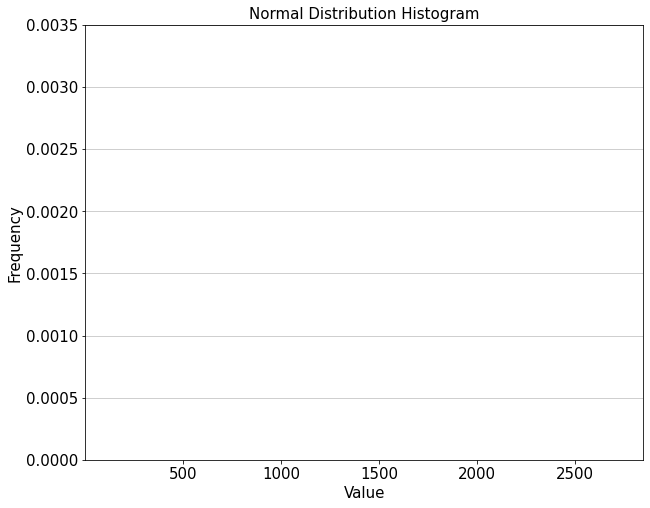

In [341]:
uCounter = defaultdict(int)
for x in reviewsPerUserCount: uCounter[x]+=1
hist,bin_edges = np.histogram(reviewsPerUserCount, density=True)
plt.figure(figsize=[10,8])
plt.bar(bin_edges[:-1], hist, width = 0.5, color='#0504aa',alpha=0.7)
plt.xlim(min(bin_edges), max(bin_edges))
plt.ylim(min(hist), max(hist))
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Normal Distribution Histogram',fontsize=15)
plt.show()

### Baseline ###
For the baseline we will have a model always predicting the average rating.

In [263]:
def MSE(predictions,labels):
    difference = [(p-l)**2 for p,l in zip(predictions,labels)]
    return sum(difference)/len(difference)

In [262]:
ratingMean = sum(ratings)/len(ratings)
print("mean: ",ratingMean)
# Baseline prediction
alwaysPredictMean = [ratingMean for d in sample]
# Baseline accuracy
baselineMean = MSE(alwaysPredictMean, sampleLabels)
print("MSE of the baseline: ", baselineMean)

mean:  3.778138356523054
MSE of the baseline:  1.2419086739076417


### Collaborative filtering ###

Different similarity functions

In [264]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    return numer/denom

In [265]:
def Pearson(i1,i2):
    u1 = usersPerItem[i1]
    u2 = usersPerItem[i2]
    common = u1.intersection(u2)
    num = []
    denom1 = []
    denom2 = []
    ratingsI1 = [d['rating'] for d in reviewsPerItem[i1]]
    ratingsI2 = [d['rating'] for d in reviewsPerItem[i2]]
    averageI1 = sum(ratingsI1)/len(ratingsI1)
    averageI2 = sum(ratingsI2)/len(ratingsI2)
    if common:
        for u in common:
            # take an average of ratings in case user rated a book multiple times
            ratingsU1 = []
            ratingsU2 = []
            for d in reviewsPerUser[u]:
                if d['book_id']==i1: ratingsU1.append(d['rating'])
                if d['book_id']==i2: ratingsU2.append(d['rating'])
            ratingU1 = sum(ratingsU1)/len(ratingsU1)
            ratingU2 = sum(ratingsU2)/len(ratingsU2)
            num.append((ratingU1-averageI1)*(ratingU2-averageI2))
            denom1.append((ratingU1-averageI1)**2)
            denom2.append((ratingU2-averageI2)**2)
        if math.sqrt(sum(denom1)*sum(denom2)) != 0:
            # normalize to 0-1 value
            return ((sum(num)/(math.sqrt(sum(denom1)*sum(denom2))))+1)/2
        else: return 0
    else: return 0

In [266]:
# two items are similar if they were rated similarly by the same users
# it's not necessary for the two items to be only rated by the same users
# similarity doesn't depend on the other users who rated only one of the two items
def Cosine(i1,i2):
    u1 = usersPerItem[i1]
    u2 = usersPerItem[i2]
    common = u1.intersection(u2)
    num = []
    denom1 = []
    denom2 = [] 
    if common:
        for u in common:
            ratingsI1 = []
            ratingsI2 = []
            for d in reviewsPerUser[u]:
                if d['book_id']==i1: ratingsI1.append(d['rating']) 
                if d['book_id']==i2: ratingsI2.append(d['rating'])
            ratingI1 = sum(ratingsI1)/len(ratingsI1)
            ratingI2 = sum(ratingsI2)/len(ratingsI2)
            num.append(ratingI1*ratingI2)
            denom1.append(ratingI1**2)
            denom2.append(ratingI2**2)
        if math.sqrt(sum(denom1)*sum(denom2)) != 0:
            return (sum(num)/(math.sqrt(sum(denom1)*sum(denom2))))
        else: return 0
    else: return 0

### Item-based collaborative filtering ###

In [267]:
def predictRating(user,item,simFunction):
    ratingsU = []
    similarities = []
    reviewsU = reviewsPerUser[user]
    for r in reviewsU:
        item2 = r['book_id']
        if item2 != item:
            ratingsU.append(r['rating'])
            if simFunction == 'Jaccard': similarities.append(Jaccard(usersPerItem[item],usersPerItem[item2]))
            elif simFunction == 'Pearson': similarities.append(Pearson(item,item2))
            elif simFunction == 'Cosine': similarities.append(Cosine(item,item2))
    if (sum(similarities)>0):
        weightedRatings = [(x*y) for x,y in zip(ratingsU,similarities)]
        return sum(weightedRatings)/sum(similarities)
    else:
        return ratingMean

In [268]:
sample = random.sample(data, 1000)
sampleLabels = [d['rating'] for d in sample]

In [269]:
# Collaborative filtering using Jaccard similarity
cfJaccard = [predictRating(d['user_id'], d['book_id'], 'Jaccard') for d in sample]
# Collaborative filtering using Pearson similarity
cfPearson = [predictRating(d['user_id'], d['book_id'], 'Pearson') for d in sample]
# Collaborative filtering using Cosine similarity
cfCosine = [predictRating(d['user_id'], d['book_id'], 'Cosine') for d in sample]

In [270]:
e = [(a,b,c,d) for a,b,c,d in zip(sampleLabels,cfJaccard,cfPearson,cfCosine)]
t = PrettyTable(['Actual rating', 'Jaccard','Pearson','Cosine'])
for r in e[:10]:
    t.add_row([r[0],r[1],r[2],r[3]])
print(t)

+---------------+--------------------+--------------------+--------------------+
| Actual rating |      Jaccard       |      Pearson       |       Cosine       |
+---------------+--------------------+--------------------+--------------------+
|       4       | 4.177317620621259  | 4.227613621426461  | 4.097173920957406  |
|       5       |        5.0         |        5.0         | 4.999999999999999  |
|       5       | 4.215851236548516  | 4.180724712546032  | 4.1264906163421236 |
|       4       | 3.9946573332033215 | 3.607718974879154  | 4.016388876631201  |
|       4       | 3.534522230182753  | 4.405163836567944  | 3.6814085829954006 |
|       4       | 3.2936960763948213 | 3.1275899583012223 | 3.251437322098181  |
|       3       | 3.263941338022942  | 2.747045823296381  | 3.307330804421289  |
|       4       | 3.0682452309852866 | 2.8447702049508163 | 3.1200425360100685 |
|       3       | 3.500327787541337  | 3.020143161707952  | 3.6547231203578274 |
|       4       | 4.11741204

In [271]:
# Collaborative filtering using Jaccard similarity accuracy
jaccardMean = MSE(cfJaccard, sampleLabels)
# Collaborative filtering using Pearson similarity accuracy
pearsonMean = MSE(cfPearson, sampleLabels)
# Collaborative filtering using Cosine similarity accuracy
cosineMean = MSE(cfCosine, sampleLabels)

In [272]:
t = PrettyTable(['Baseline', 'Jaccard','Pearson','Cosine'])
t.add_row([baselineMean,jaccardMean,pearsonMean,cosineMean])
print(t)

+--------------------+--------------------+--------------------+--------------------+
|      Baseline      |      Jaccard       |      Pearson       |       Cosine       |
+--------------------+--------------------+--------------------+--------------------+
| 1.2419086739076417 | 1.1889606213456008 | 0.9005357309111561 | 1.1838656107222214 |
+--------------------+--------------------+--------------------+--------------------+


### User-based collaborative filtering ###

In [273]:
def Pearson2(u1,u2):
    i1 = itemsPerUser[u1]
    i2 = itemsPerUser[u2]
    common = i1.intersection(i2)
    num = []
    denom1 = []
    denom2 = []
    ratingsI1 = [d['rating'] for d in reviewsPerUser[u1]]
    ratingsI2 = [d['rating'] for d in reviewsPerUser[u2]]
    averageI1 = sum(ratingsI1)/len(ratingsI1)
    averageI2 = sum(ratingsI2)/len(ratingsI2)
    if common:
        for i in common:
            # take an average of ratings in case user rated a book multiple times
            ratingsU1 = []
            ratingsU2 = []
            for d in reviewsPerItem[i]:
                if d['user_id']==u1: ratingsU1.append(d['rating'])
                if d['user_id']==u2: ratingsU2.append(d['rating'])
            ratingU1 = sum(ratingsU1)/len(ratingsU1)
            ratingU2 = sum(ratingsU2)/len(ratingsU2)
            num.append((ratingU1-averageI1)*(ratingU2-averageI2))
            denom1.append((ratingU1-averageI1)**2)
            denom2.append((ratingU2-averageI2)**2)
        if math.sqrt(sum(denom1)*sum(denom2)) != 0:
            # normalize to 0-1 value
            return ((sum(num)/(math.sqrt(sum(denom1)*sum(denom2))))+1)/2
        else: return 0
    else: return 0

In [274]:
# two items are similar if they were rated similarly by the same users
# it's not necessary for the two items to be only rated by the same users
# similarity doesn't depend on the other users who rated only one of the two items
def Cosine2(u1,u2):
    i1 = itemsPerUser[u1]
    i2 = itemsPerUser[u2]
    common = i1.intersection(i2)
    num = []
    denom1 = []
    denom2 = [] 
    if common:
        for i in common:
            ratingsI1 = []
            ratingsI2 = []
            for d in reviewsPerItem[i]:
                if d['user_id']==u1: ratingsI1.append(d['rating']) 
                if d['user_id']==u2: ratingsI2.append(d['rating'])
            ratingI1 = sum(ratingsI1)/len(ratingsI1)
            ratingI2 = sum(ratingsI2)/len(ratingsI2)
            num.append(ratingI1*ratingI2)
            denom1.append(ratingI1**2)
            denom2.append(ratingI2**2)
        if math.sqrt(sum(denom1)*sum(denom2)) != 0:
            return (sum(num)/(math.sqrt(sum(denom1)*sum(denom2))))
        else: return 0
    else: return 0

In [279]:
def predictRating2(user,item,simFunction):
    ratingsI = [] 
    similarities = []
    reviewsI = reviewsPerItem[item]
    for r in reviewsI:
        user2 = r['user_id']
        if user2 != user:
            ratingsI.append(r['rating'])
            if simFunction == 'Jaccard': similarities.append(Jaccard(itemsPerUser[user],itemsPerUser[user2]))
            elif simFunction == 'Pearson': similarities.append(Pearson2(user,user2))
            elif simFunction == 'Cosine': similarities.append(Cosine2(user,user2))
    if (sum(similarities)>0):
        weightedRatings = [(x*y) for x,y in zip(ratingsI,similarities)]
        return sum(weightedRatings)/sum(similarities)
    else:
        return ratingMean

In [280]:
# Collaborative filtering using Jaccard similarity
cfJaccard = [predictRating2(d['user_id'], d['book_id'], 'Jaccard') for d in sample]

In [281]:
# Collaborative filtering using Pearson similarity
cfPearson = [predictRating2(d['user_id'], d['book_id'], 'Pearson') for d in sample]

In [282]:
# Collaborative filtering using Cosine similarity
cfCosine = [predictRating2(d['user_id'], d['book_id'], 'Cosine') for d in sample]

In [283]:
e = [(a,b,c,d) for a,b,c,d in zip(sampleLabels,cfJaccard,cfPearson,cfCosine)]
t = PrettyTable(['Actual rating', 'Jaccard','Pearson','Cosine'])
for r in e[:10]:
    t.add_row([r[0],r[1],r[2],r[3]])
print(t)

+---------------+--------------------+-------------------+--------------------+
| Actual rating |      Jaccard       |      Pearson      |       Cosine       |
+---------------+--------------------+-------------------+--------------------+
|       4       | 3.9309659571724844 | 3.634569102382883 | 4.031498274640546  |
|       5       | 4.591164799582852  | 3.778138356523054 | 4.374659603929579  |
|       5       | 3.8767190762447186 | 4.382285577718255 | 3.9403808468835457 |
|       4       | 4.1655798012818135 | 4.001213524045969 | 4.162238155191455  |
|       4       | 2.677064220183486  | 4.021994985878709 | 3.4866028503133712 |
|       4       | 4.043337591401535  | 4.412435555441704 | 4.1168247965542495 |
|       3       | 4.402808815162322  | 4.269502398210095 | 4.452452261197568  |
|       4       | 4.818461410581439  | 4.601111932581552 | 4.663377938479384  |
|       3       | 3.0803213727864684 |  3.61660362653899 | 4.205730338544932  |
|       4       | 4.633100643558225  | 4

In [284]:
# Collaborative filtering using Jaccard similarity accuracy
jaccardMean = MSE(cfJaccard, sampleLabels)
# Collaborative filtering using Pearson similarity accuracy
pearsonMean = MSE(cfPearson, sampleLabels)
# Collaborative filtering using Cosine similarity accuracy
cosineMean = MSE(cfCosine, sampleLabels)

In [285]:
t = PrettyTable(['Baseline', 'Jaccard','Pearson','Cosine'])
t.add_row([baselineMean,jaccardMean,pearsonMean,cosineMean])
print(t)

+--------------------+--------------------+--------------------+-------------------+
|      Baseline      |      Jaccard       |      Pearson       |       Cosine      |
+--------------------+--------------------+--------------------+-------------------+
| 1.2419086739076417 | 1.3638055917345377 | 1.0278324622457868 | 1.309326145989496 |
+--------------------+--------------------+--------------------+-------------------+
